In [455]:
# Lib & Dependencies
import os
import math
import gc
import pickle
import json
from datetime import datetime

import pandas as pd
import numpy as np
import xgboost as xgb
import scipy as sp
import category_encoders as ce
import seaborn as sns
import plotly.express as px

from lightgbm import LGBMClassifier
import catboost as cb
from scipy import stats
from tqdm import tqdm
from itertools import combinations
from tsfresh.feature_extraction import feature_calculators

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ridge_regression, RidgeCV, LassoCV, BayesianRidge, LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import scipy
import numpy as np
from scipy.cluster import hierarchy as hc
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize':(12, 5), 'figure.dpi':100})

In [456]:
df = pd.read_csv('data/train.csv')

In [457]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,1,1,1,0,1,1,1,18.605397,f,White-European,no,no,United States,no,7.819715,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,1,13.829369,f,South Asian,no,no,Australia,no,10.544296,18 and more,?,0
2,3,1,1,1,1,1,1,0,0,1,1,14.679893,f,White-European,no,no,United Kingdom,no,13.167506,18 and more,Self,1
3,4,0,0,0,1,0,0,0,0,0,0,61.035288,f,South Asian,no,no,New Zealand,no,1.530098,18 and more,?,0
4,5,0,0,0,0,1,0,0,0,1,1,14.256686,m,Black,no,yes,Italy,no,7.949723,18 and more,Self,0


In [458]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [459]:
df.shape

(800, 22)

In [460]:
df= df.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_residence'})

## EDA

In [461]:
cat_cols = df.select_dtypes('object').columns

In [462]:
for x in cat_cols:
    print(f'==========={x}============')
    print(df[x].value_counts())

===========gender============
f    415
m    385
Name: gender, dtype: int64
===========ethnicity============
White-European     211
?                  151
Asian              134
Middle Eastern     116
Black               45
Latino              44
South Asian         35
Others              24
Pasifika            18
Hispanic            16
Turkish              4
others               2
Name: ethnicity, dtype: int64
===========jaundice============
no     604
yes    196
Name: jaundice, dtype: int64
===========autism============
no     683
yes    117
Name: autism, dtype: int64
===========country_of_residence============
United States           148
United Arab Emirates     94
New Zealand              93
India                    74
United Kingdom           58
                       ... 
Sierra Leone              1
Tonga                     1
Iraq                      1
Bangladesh                1
Uruguay                   1
Name: country_of_residence, Length: 61, dtype: int64
===========used_app

Column age_desc has only one value, it's been removed

In [463]:
df.drop(['age_desc', 'ID'], axis=1, inplace=True)

We also see a '?' as values, wwe changed this to NaN

In [464]:
df.replace('?', np.nan, inplace=True) 

Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes

In [465]:
df['Class/ASD'] = df['Class/ASD'].map({0:'No', 1:'Yes'})

In [466]:
df['autism'] = df['autism'].str.capitalize()
df['used_app_before'] = df['used_app_before'].str.capitalize()
df['jaundice'] = df['jaundice'].str.capitalize()
df['ethnicity'] = df['ethnicity'].str.strip(' ')
df['gender'] = df['gender'].map({'m':'Male', 'f':'Female'})

In [467]:
df['ethnicity'] = df['ethnicity'].replace(np.nan, 'Others')
df['ethnicity'] = df['ethnicity'].replace('others', 'Others')

In [468]:
cat_cols = df.select_dtypes('object').columns

## Bivariate Analysis

ethnicity - Ethnicity of the patient

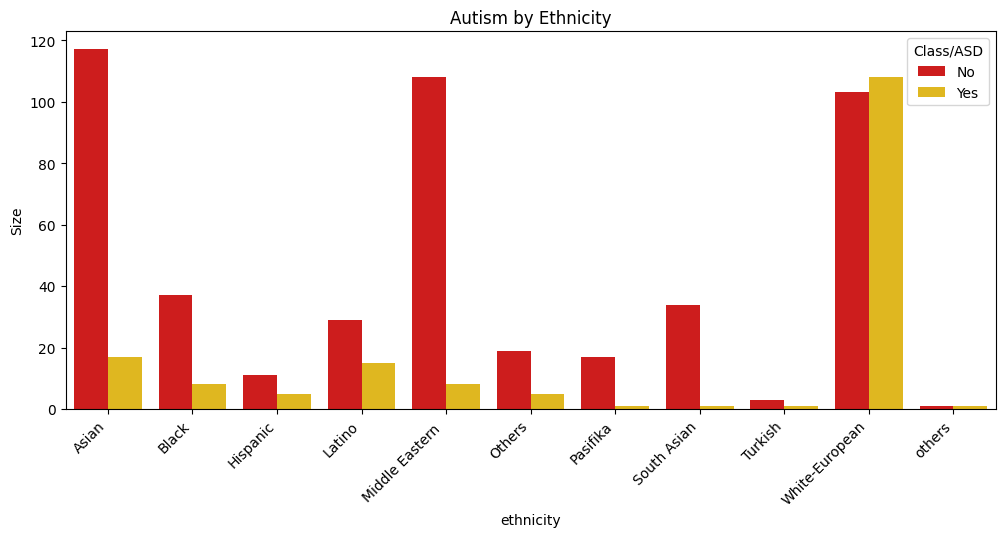

In [108]:
ethnicity = df.groupby(['ethnicity','Class/ASD']).size().reset_index(name='Size')
ax = sns.barplot(data=ethnicity, x="ethnicity", y="Size", hue='Class/ASD', palette='hot')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="right")
plt.title("Autism by Ethnicity");

jaundice - Whether the patient had jaundice at the time of birth

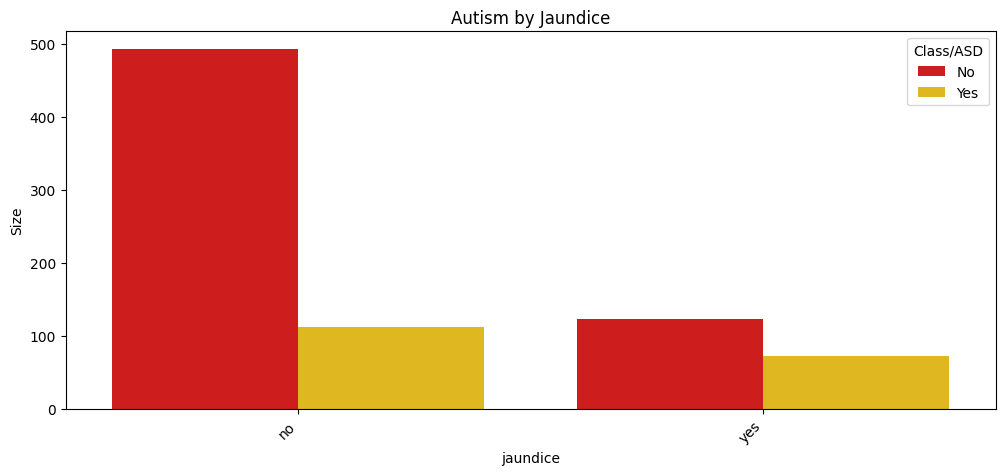

In [107]:
jaundice = df.groupby(['jaundice','Class/ASD']).size().reset_index(name='Size')
ax = sns.barplot(data=jaundice, x="jaundice", y="Size", hue='Class/ASD', palette='hot')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="right")
plt.title("Autism by Jaundice");

relation - Relation of patient who completed the test

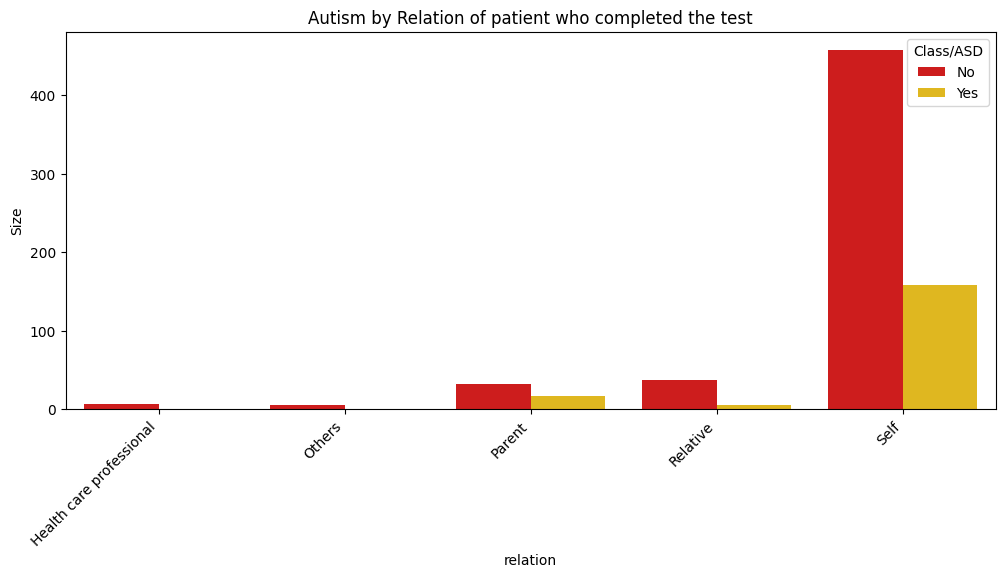

In [106]:
relation = df.groupby(['relation','Class/ASD']).size().reset_index(name='Size')
ax = sns.barplot(data=relation, x="relation", y="Size", hue='Class/ASD', palette='hot')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="right")
plt.title("Autism by Relation of patient who completed the test");

used_app_before - Whether the patient has undergone a screening test before

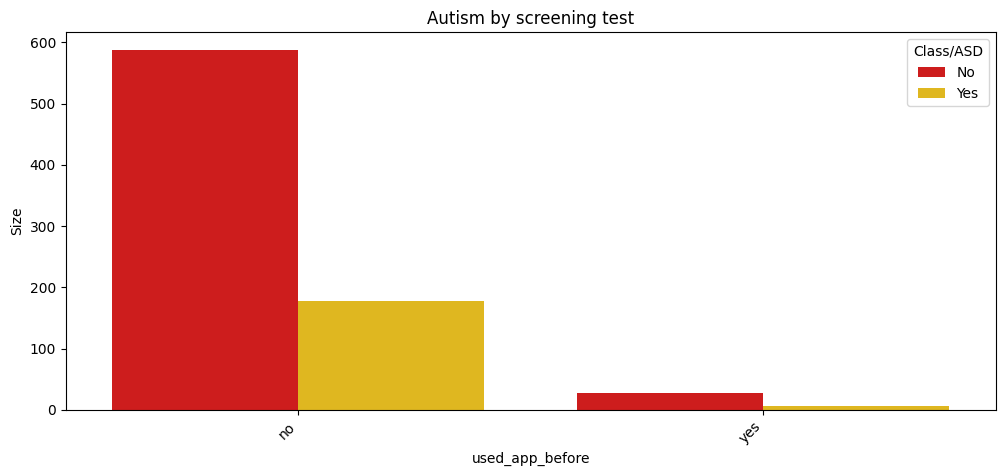

In [109]:
used_app_before = df.groupby(['used_app_before','Class/ASD']).size().reset_index(name='Size')
ax = sns.barplot(data=used_app_before, x="used_app_before", y="Size", hue='Class/ASD', palette='hot')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha="right")
plt.title("Autism by screening test");

age - Age of the patient in years

Text(0.5, 1.0, 'Austism by Age')

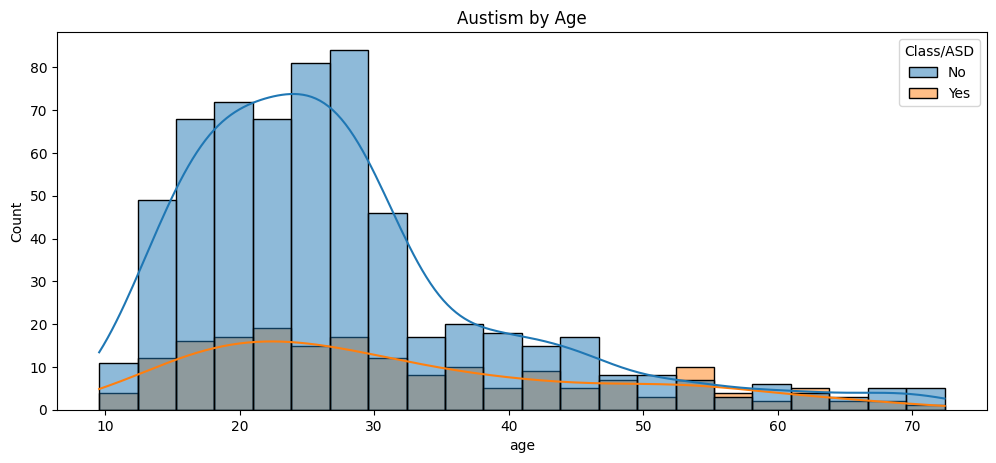

In [104]:
age =df.groupby(['age','Class/ASD']).size().reset_index(name="size")
sns.histplot(data=age,x='age',hue="Class/ASD" , kde=True );
plt.title("Austism by Age")

## Machine Learning

In [150]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import gc
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample
#optional but advised
import warnings
warnings.filterwarnings('ignore')

#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 1000 #number of hyperopt evaluation rounds
N_FOLDS = 5 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**11 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 500  #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'rmse' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'auc'#LightGBM classification metric

#XGBOOST PARAMETERS
XGB_MAX_LEAVES = 2**12 #maximum number of leaves when using histogram splitting
XGB_MAX_DEPTH = 45 #maximum tree depth for XGBoost
EVAL_METRIC_XGB_REG = 'rmse' #XGBoost regression metric
EVAL_METRIC_XGB_CLASS = 'auc' #XGBoost classification metric

#CATBOOST PARAMETERS
CB_MAX_DEPTH = 8 #maximum tree depth in CatBoost
OBJECTIVE_CB_REG = 'MAE' #CatBoost regression metric
OBJECTIVE_CB_CLASS = 'Logloss' #CatBoost classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0

def quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
            
#             best_loss = cv_results['rmse-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
#         metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_class

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)

Label Encode Categorical Variables

In [469]:
cat_cols = [x for x in cat_cols if x != 'Class/ASD']

In [470]:
cat_cols

['gender',
 'ethnicity',
 'jaundice',
 'autism',
 'country_of_residence',
 'used_app_before',
 'relation']

In [471]:
label_encode_dict = {}

In [472]:
# Label encode my categorical columns
for i in cat_cols:
    print(i)
    le = LabelEncoder()
    df[i] = df[i].astype('str')
    df[i] = le.fit_transform(df[i])
    le_enc_df = pd.DataFrame({'name':le.inverse_transform(df[i]), 'inverse':df[i]})
    label_encode_dict[i] = (le_enc_df.drop_duplicates('name').set_index('name').to_dict()['inverse'])

gender
ethnicity
jaundice
autism
country_of_residence
used_app_before
relation


In [473]:
df['Class/ASD'] = df['Class/ASD'].map({'No':0, 'Yes':1})

In [474]:
label_encode_dict['Class/ASD'] = {'No':0, 'Yes':1}

In [475]:
with open('autism_web_app/model/label_encode.json', 'w') as file:
    json.dump(label_encode_dict, file)

In [477]:
# params = quick_hyperopt(df, df['Class/ASD'], 'lgbm', 100)

In [478]:
params = {'bagging_fraction': 0.78,
 'boosting': 'goss',
 'feature_fraction': 0.7000000000000001,
 'lambda_l1': 2.142844888144765,
 'lambda_l2': 2.275616988303392,
 'learning_rate': 0.08336932730727828,
 'max_bin': 157,
 'max_depth': 223,
 'metric': 'auc',
 'min_data_in_bin': 94,
 'min_data_in_leaf': 121,
 'min_gain_to_split': 3.91,
 'num_leaves': 444,
 'objective': 'cross_entropy',
 'other_rate': 0.49937857790027973,
 'top_rate': 0.13592583994946528}

In [479]:
model = LGBMClassifier(**params)

In [480]:
model.fit(df.drop('Class/ASD', axis=1), df['Class/ASD'])

LGBMClassifier(bagging_fraction=0.78, boosting='goss',
               feature_fraction=0.7000000000000001, lambda_l1=2.142844888144765,
               lambda_l2=2.275616988303392, learning_rate=0.08336932730727828,
               max_bin=157, max_depth=223, metric='auc', min_data_in_bin=94,
               min_data_in_leaf=121, min_gain_to_split=3.91, num_leaves=444,
               objective='cross_entropy', other_rate=0.49937857790027973,
               top_rate=0.13592583994946528)

Save Model

In [481]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'country_of_residence',
       'used_app_before', 'result', 'relation', 'Class/ASD'],
      dtype='object')

In [482]:
pickle.dump(model, open('autism_web_app/model/lgbm.pkl', 'wb'))